# Finetune model on Old English Electronic Corpus

## Data

We load the electronic corpus of Old English using a custome Dataset class (see `text_anomalies/dataloader.py`).

In [1]:
import sys
sys.path.append("../")
import text_anomalies as ta

sentences = ta.OldEnglishDataset("../data/doec.parquet")

/data.nst/smohr/anaconda3/envs/text_anomalies/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Split into train, validation, and test sets
from torch.utils.data import random_split

split = [0.8, 0.1, 0.1]

train, val, test = random_split(
    sentences, 
    split,
)

### Explore the dataset

In [3]:
# How many samples are included in the dataset?
print(f"Total: {len(train)} sentences")
print(f"Train: {len(train)} sentences")
print(f"Validation: {len(val)} sentences")
print(f"Test: {len(test)} sentences")

Total: 161801 sentences
Train: 161801 sentences
Validation: 20225 sentences
Test: 20225 sentences


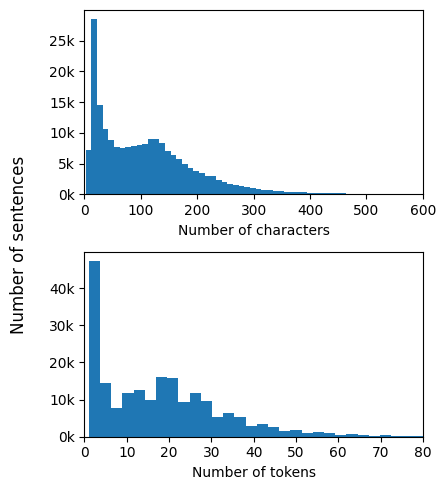

In [17]:
# Visualize the length of the sentences in characters
# Visualize the length of the sentences in tokens
import matplotlib.pyplot as plt

# Calculate the length of each sentence
lengths_char = [len(sentence) for sentence in sentences]
lengths_token = [len(sentence.split(" ")) for sentence in sentences]

# Plot 
fig, axes = plt.subplots(2,1, figsize=(4.5, 5))
fig.supylabel("Number of sentences")
axes[0].set_xlabel("Number of characters")
axes[0].set_xlim(0, 600)
axes[0].hist(lengths_char, bins=200)

axes[1].set_xlabel("Number of tokens")
axes[1].set_xlim(0, 80)
axes[1].hist(lengths_token, bins=100);

# k formatter for y-axis add k 
from matplotlib.ticker import FuncFormatter
axes[0].yaxis.set_major_formatter(
    FuncFormatter(lambda y, _: '{:.0f}k'.format(y/1000))
)
axes[1].yaxis.set_major_formatter(
    FuncFormatter(lambda y, _: '{:.0f}k'.format(y/1000))
)

fig.set_tight_layout(True)

## Training method

As we use a different language from the existing ones in the model, we need to finetune the model on the Old English corpus.

Here we need to train the tokenizer and the model on the Old English corpus.

### Tokenizer

- Break words into subwords
- Add special tokens (end, begin, padding)

### Model




Here we define old functions needed for training and validating the model. We opt to use some tpyical implementations.

- Adam optimizer
- Cross entropy loss
- Learning rate scheduler (reduce on plateau)
- Early stopping

We split the data into training and validation sets. The training set is used to train the model, and the validation set is used to validate the model. The validation set is used to prevent overfitting. We use 15% of the data as the validation set.


In [ ]:
import fastprogress

def train(dataloader, optimizer, model, loss_fn, device, master_bar):
    """Run one training epoch.

    Args:
        dataloader (DataLoader): Torch DataLoader object to load data
        optimizer: Torch optimizer object
        model (nn.Module): Torch model to train
        loss_fn: Torch loss function
        device (torch.device): Torch device to use for training
        master_bar (fastprogress.master_bar): Will be iterated over for each
            epoch to draw batches and display training progress

    Returns:
        float, float: Mean loss of this epoch, fraction of correct predictions
            on training set (accuracy)
    """
    epoch_loss = []
    epoch_correct, epoch_total = 0, 0

    for features, labels, attention_masks in fastprogress.progress_bar(dataloader, parent=master_bar):
        optimizer.zero_grad()
        model.train()

        # Get data from dataloader
        features = features.to(device)
        labels = labels.to(device)
      
        # Forward pass
        if model.with_attention_masks:
          labels_pred = model(features, attention_masks.to(device))
        else:
          labels_pred = model(features)

        # For calculating the accuracy, save the number of correctly classified 
        # texts and the total number
        epoch_correct += sum(labels == labels_pred.argmax(dim=-1))
        epoch_total += len(labels)

        # Compute loss
        loss = loss_fn(labels_pred, labels)

        # Backward pass
        loss.backward()
        optimizer.step()

        # For plotting the train loss, save it for each sample
        epoch_loss.append(loss.item())

    # Return the mean loss and the accuracy of this epoch
    return np.mean(epoch_loss), accuracy(epoch_correct, epoch_total)
